In [1]:
# Little Jupyter notebook to explore time series data from in situ stations and satellite observations,
# both already in csv format.

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

os.chdir('/home/arthur/Dropbox/projects/greenland/station_data/appears_extraction')
all_data_mcd = pd.read_csv('greenland-stations-MCD43A3-006-results.csv', index_col=0)

os.chdir('/home/arthur/Dropbox/projects/greenland/station_data/tower_data/orig_data_std_format/')
stn_df = pd.read_csv('South_Dome_11c.csv')
print(stn_df.columns)

# Column variables for readability
date = 'Date'
mcd43a3_sw_wsa = 'MCD43A3_006_Albedo_WSA_shortwave'
mcd43a3_sw_qa = 'MCD43A3_006_BRDF_Albedo_Band_Mandatory_Quality_shortwave'

# Specify whether to keep QA == 1, i.e. magnitude inversions

all_qa = True

Index(['year', 'dec_day', 'sw_down', 'sw_up', 'net_rad', 'alb'], dtype='object')


In [2]:
# Subset and mask station data
 #.loc['alb']

# Filter out non-noon observations from dataset
#TODO Can't figure out why these two filters cannot be combined into single line
filter = stn_df['dec_day'] % 0.5 == 0
stn_df.where(filter, inplace = True)

filter = stn_df['dec_day'] % 1.0 != 0
stn_df.where(filter, inplace = True)

# Remove observations filtered out above
stn_df = stn_df.dropna()

# Clean up dec_days and combine wit.h year to make new date field in yyyy-mm-dd, use as index
stn_df['dec_day'] = stn_df['dec_day'].apply(np.floor)
stn_df['dec_day'] = stn_df['dec_day'].astype(int).astype(str)
stn_df['dec_day'] = stn_df['dec_day'].str.zfill(3)
stn_df['date'] = stn_df['year'].astype(int).astype(str) + stn_df['dec_day']
stn_df['date'] = pd.to_datetime(stn_df['date'], format='%Y%j')
stn_df = stn_df.set_index(stn_df['date'])

# Delete now unnecessary dateparts
del stn_df['year']
del stn_df['dec_day']

# Set albedo fill values to NaN
stn_df['alb'].mask(stn_df['alb'] == 999, np.NaN, inplace=True)

print(stn_df)

            sw_down   sw_up  net_rad   alb       date
date                                                 
2015-01-01     0.25    0.14    -5.83  0.95 2015-01-01
2015-01-02     0.25    0.14    -2.01  0.95 2015-01-02
2015-01-03     0.25    0.07    -5.04  0.95 2015-01-03
2015-01-04     0.12    0.07    -2.35  0.95 2015-01-04
2015-01-05     0.19    0.14    -3.16  0.95 2015-01-05
...             ...     ...      ...   ...        ...
2019-05-15   467.36  428.92    20.28  0.92 2019-05-15
2019-05-16   469.46  440.88  -194.10  0.94 2019-05-16
2019-05-17   480.13  448.09    43.47  0.93 2019-05-17
2019-05-18   491.16  441.36  -112.55  0.90 2019-05-18
2019-05-19   454.21  423.68   -17.47  0.93 2019-05-19

[1600 rows x 5 columns]


In [3]:
# Subset and mask mcd43 data
mcd_df = all_data_mcd.loc['NASA-U', [date, mcd43a3_sw_wsa, mcd43a3_sw_qa]]

# Mask out fill values
mcd_df[mcd43a3_sw_wsa].mask(mcd_df[mcd43a3_sw_qa] == 255, np.NaN, inplace=True)

# If specified, remove QA == 1
if all_qa:
    mcd_df[mcd43a3_sw_wsa].mask(mcd_df[mcd43a3_sw_qa] == 1, np.NaN, inplace=True)

print(mcd_df)


                Date  MCD43A3_006_Albedo_WSA_shortwave  \
Category                                                 
NASA-U    2000-02-24                               NaN   
NASA-U    2000-02-25                               NaN   
NASA-U    2000-02-26                               NaN   
NASA-U    2000-02-27                               NaN   
NASA-U    2000-02-28                               NaN   
...              ...                               ...   
NASA-U    2020-04-28                             0.835   
NASA-U    2020-04-29                             0.826   
NASA-U    2020-04-30                             0.823   
NASA-U    2020-05-01                             0.820   
NASA-U    2020-05-02                             0.820   

          MCD43A3_006_BRDF_Albedo_Band_Mandatory_Quality_shortwave  
Category                                                            
NASA-U                                                255.0         
NASA-U                                

0.08900909530839558


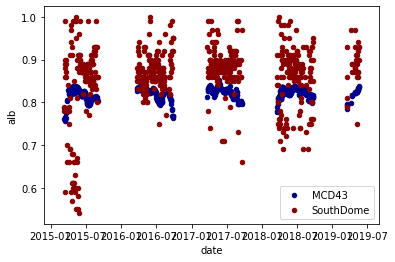

In [4]:
# Plot data
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
#plt.style.use("ggplot")

mcd_df[date] = pd.to_datetime(mcd_df[date], yearfirst=True)
mcd_df = mcd_df.set_index(mcd_df[date])

# Join satellite observations to stn data based on date
joined_df = mcd_df.join(stn_df, lsuffix='_mcd', rsuffix='_stn')

 #del joined_df['date']
del joined_df['MCD43A3_006_BRDF_Albedo_Band_Mandatory_Quality_shortwave']
del joined_df['sw_down']
del joined_df['sw_up']
del joined_df['net_rad']
del joined_df['Date']

# Subset dataset to correct time period (different for different stations?
joined_subset_df = joined_df.loc['2015-01-01':'2019-08-01']

# Calculate stats on dataset that has no missing values
joined_subset_no_nans_df = joined_df.dropna()
sw_wsa_mse = mean_squared_error(joined_subset_no_nans_df[mcd43a3_sw_wsa], joined_subset_no_nans_df['alb'])
sw_wsa_rmse = math.sqrt(sw_wsa_mse)
print(sw_wsa_rmse)

# Do plot
#ax1 = joined_subset_df.plot(kind='scatter', y='alb', x='date', use_index=True)
#joined_subset_df.plot(kind='scatter', y=mcd43a3_sw_wsa, x='date', use_index=True, ax=ax1)

# Add back in the missing days in a plottable way
joined_subset_no_nans_filled_df = joined_subset_no_nans_df.asfreq('D')

ax = joined_subset_no_nans_filled_df.plot(kind='scatter', x='date', y=mcd43a3_sw_wsa, color='DarkBlue', label='MCD43')
joined_subset_no_nans_filled_df.plot(kind='scatter', x='date', y='alb', ax=ax, color='DarkRed', label='SouthDome')
# joined_subset_df.plot(kind='scatter', y='alb', x='date', use_index=True)
# joined_subset_df.plot(kind='scatter', y=mcd43a3_sw_wsa, x='date', use_index=True)
#
# # Export csv if needed
# joined_subset_no_nans_filled_df.to_csv('test.csv')


